/data/zju/ty/miniconda/envs/celloracle/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/data/zju/ty/miniconda/envs/celloracle/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/data/

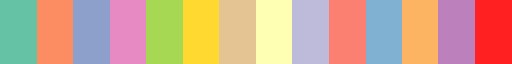

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
import matplotlib
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300
colorlist = ["#66C2A5", "#FC8D62", "#8DA0CB","#E78AC3","#A6D854", "#FFD92F", "#E5C494", "#FFFFB3", "#BEBADA", "#FB8072","#80B1D3" ,"#FDB462", "#BC80BD","#ff2121"]
matplotlib.colors.ListedColormap(colorlist, name='colorlist')

In [2]:
base_GRN = co.data.load_drosophila_promoter_base_GRN()
adata = sc.read_h5ad("/data/zju/tianfeng/workspace/tianfeng/single_cell_atlas/processed_data_file/ctrl_velo.h5ad")
#for Human
#base_GRN = co.data.load_human_promoter_base_GRN()

Loading prebuilt promoter base-GRN. Version: dm6_CisBPv2_fpr2


In [3]:
base_GRN.head()
#check data

,peak_id,gene_short_name,AP-2,Abd-B,Adf1,Aef1,Antp,Asciz,Atf-2,Atf3,...,usp,vfl,vnd,vri,vvl,wor,yps,z,zen,zen2
0,chr2L_10002636_10002831,SoYb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr2L_10002832_10003932,Ndf,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,chr2L_10004943_10006043,asRNA:CR44873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr2L_10008381_10009353,Trp1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr2L_10009354_10010454,Trp1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# preprocess
sc.pp.highly_variable_genes(adata, "spliced", flavor='seurat_v3', n_top_genes=3000, subset=True)

In [5]:
# Check data in anndata
#scRNA-seq如果较多可能需要筛选采样，2-3w，超过3000genes可能有问题

print(f"Cell number is :{adata.shape[0]}")
print(f"Gene number is :{adata.shape[1]}")
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

Cell number is :9615
Gene number is :3000
Metadata columns : ['orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.1', 'seurat_clusters', 'Classification1']
Dimensional reduction:  ['X_pca', 'X_umap']


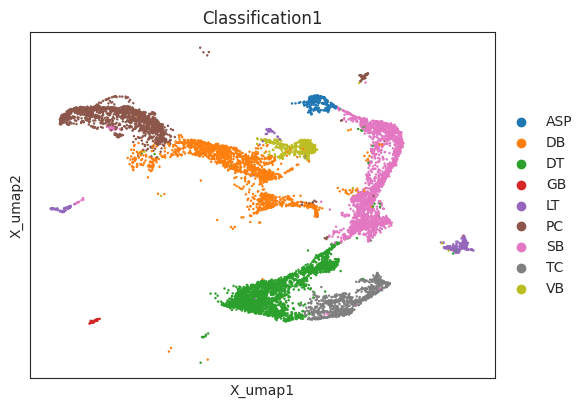

In [6]:
adata.X = adata.layers["spliced"].copy()

# Instantiate Oracle object
oracle = co.Oracle()
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="Classification1",
                                   embedding_name="X_umap")
oracle.import_TF_data(TF_info_matrix=base_GRN)#添加TF字典信息！

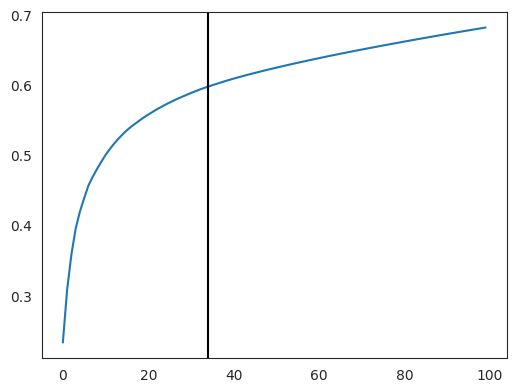

34


In [7]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [8]:
k = int(0.025*oracle.adata.shape[0])
print(f"Auto-selected k is: {k}")
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=12)

Auto-selected k is: 240


In [9]:
oracle.to_hdf5("../processed_data_file/ctrl.celloracle.oracle")

In [10]:
oracle.adata

AnnData object with n_obs × n_vars = 9615 × 3000
    obs: 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.1', 'seurat_clusters', 'Classification1'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators'
    uns: 'hvg', 'log1p', 'Classification1_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'raw_count', 'normalized_count', 'imputed_count'

In [11]:
oracle.adata.uns['Classification1_colors']

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22']

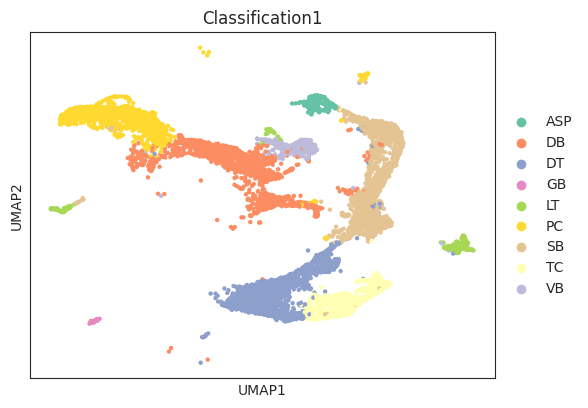

In [12]:
# Check clustering data
sc.pl.umap(adata, color=['Classification1'], size=40, palette = colorlist)

In [13]:
links = oracle.get_links(cluster_name_for_GRN_unit="Classification1", alpha=10, verbose_level=10)

  0%|          | 0/9 [00:00<?, ?it/s]

Inferring GRN for ASP...


  0%|          | 0/2847 [00:00<?, ?it/s]

Inferring GRN for DB...


  0%|          | 0/2847 [00:00<?, ?it/s]

Inferring GRN for DT...


  0%|          | 0/2847 [00:00<?, ?it/s]

Inferring GRN for GB...


  0%|          | 0/2847 [00:00<?, ?it/s]

Inferring GRN for LT...


  0%|          | 0/2847 [00:00<?, ?it/s]

Inferring GRN for PC...


  0%|          | 0/2847 [00:00<?, ?it/s]

Inferring GRN for SB...


  0%|          | 0/2847 [00:00<?, ?it/s]

Inferring GRN for TC...


  0%|          | 0/2847 [00:00<?, ?it/s]

Inferring GRN for VB...


  0%|          | 0/2847 [00:00<?, ?it/s]

In [14]:
print(links.links_dict.keys())
links.links_dict["PC"]

dict_keys(['ASP', 'DB', 'DT', 'GB', 'LT', 'PC', 'SB', 'TC', 'VB'])


,source,target,coef_mean,coef_abs,p,-logp
0,schlank,14-3-3epsilon,0.575472,0.575472,1.521723e-43,42.817664
1,E(spl)m5-HLH,18w,-0.089193,0.089193,3.482734e-02,1.458080
2,slp1,18w,-0.044628,0.044628,7.051391e-07,6.151725
3,fd19B,18w,0.036653,0.036653,9.939784e-11,10.002623
4,h,18w,0.266559,0.266559,5.526604e-13,12.257542
...,...,...,...,...,...,...
34144,rn,zyd,0.012990,0.012990,2.390634e-09,8.621487
34145,pdm3,zyd,0.035680,0.035680,1.008873e-11,10.996163
34146,dmrt99B,zyd,-0.003530,0.003530,6.351530e-07,6.197122
34147,H15,zyd,0.006446,0.006446,2.368720e-07,6.625486


In [15]:
# Set cluster name
cluster = "PC"

# Save as csv
links.links_dict[cluster].to_csv(f"../data_tables/raw_GRN_for_{cluster}.csv")

In [16]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
links.to_hdf5(file_path="../processed_data_file/links.celloracle.links")

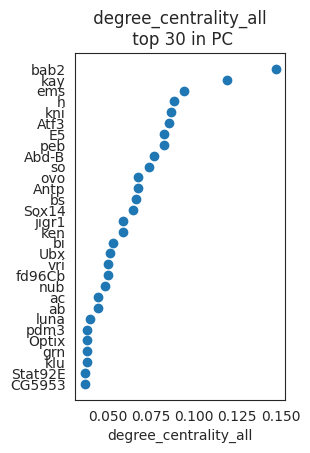

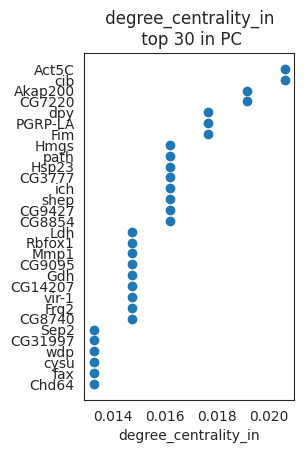

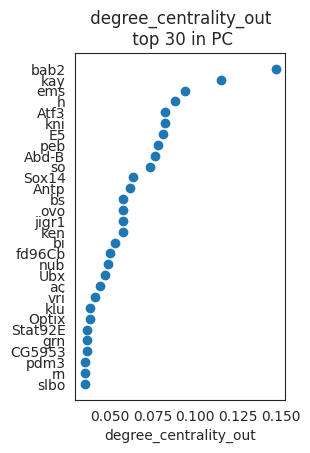

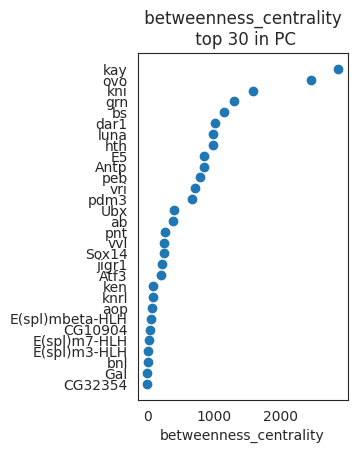

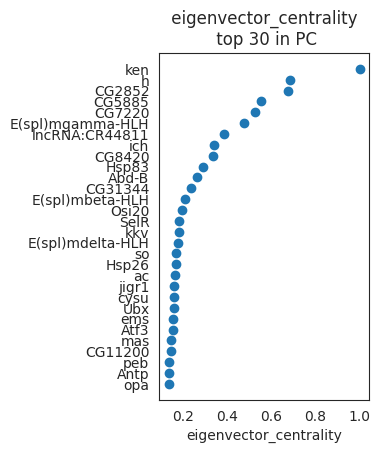

In [17]:
links.plot_scores_as_rank(cluster="PC", n_gene=30)

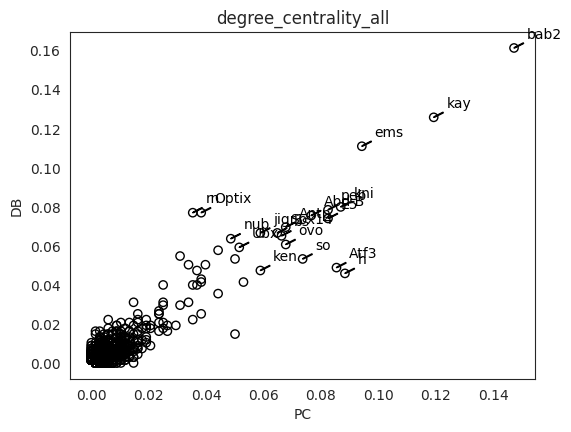

In [18]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="degree_centrality_all",
                               cluster1="PC", cluster2="DB",
                               percentile=98)

kni


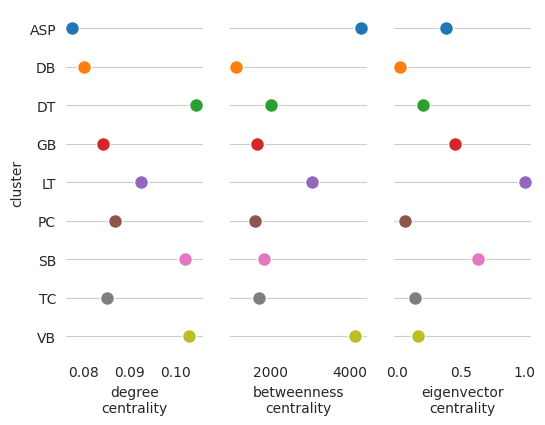

In [19]:
# Visualize key regulator network score dynamics
links.plot_score_per_cluster(goi="kni")

# in silico TF perturbation

In [20]:
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10,
                              use_cluster_specific_TFdict=True)

  0%|          | 0/9 [00:00<?, ?it/s]

In [34]:
# Check gene expression
goi = "fng"
sc.pl.umap(oracle.adata, color=[goi, oracle.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

KeyError: 'Could not find key RBPJ in .var_names or .obs.columns.'

<Figure size 1374x450 with 0 Axes>

In [33]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0}, n_propagation=3)

# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

ValueError: Gene fng is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.

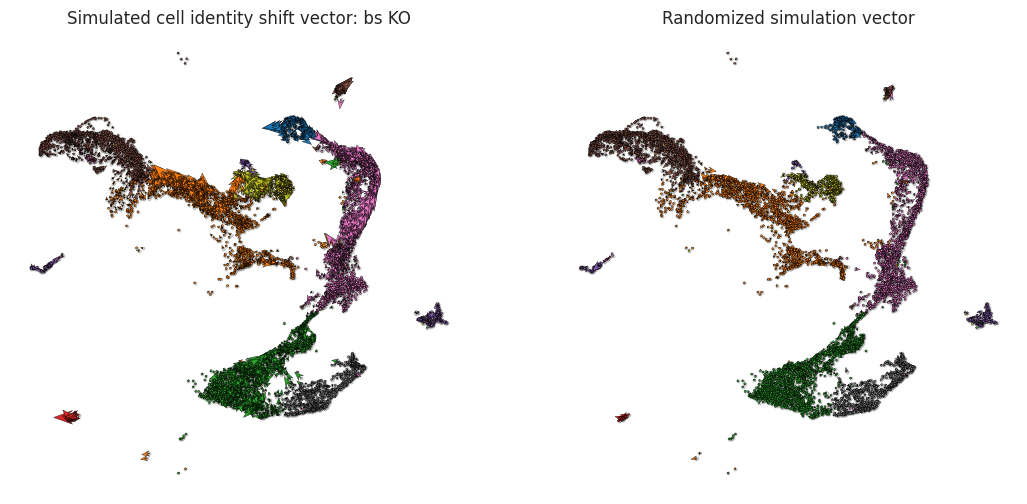

In [ ]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 40
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

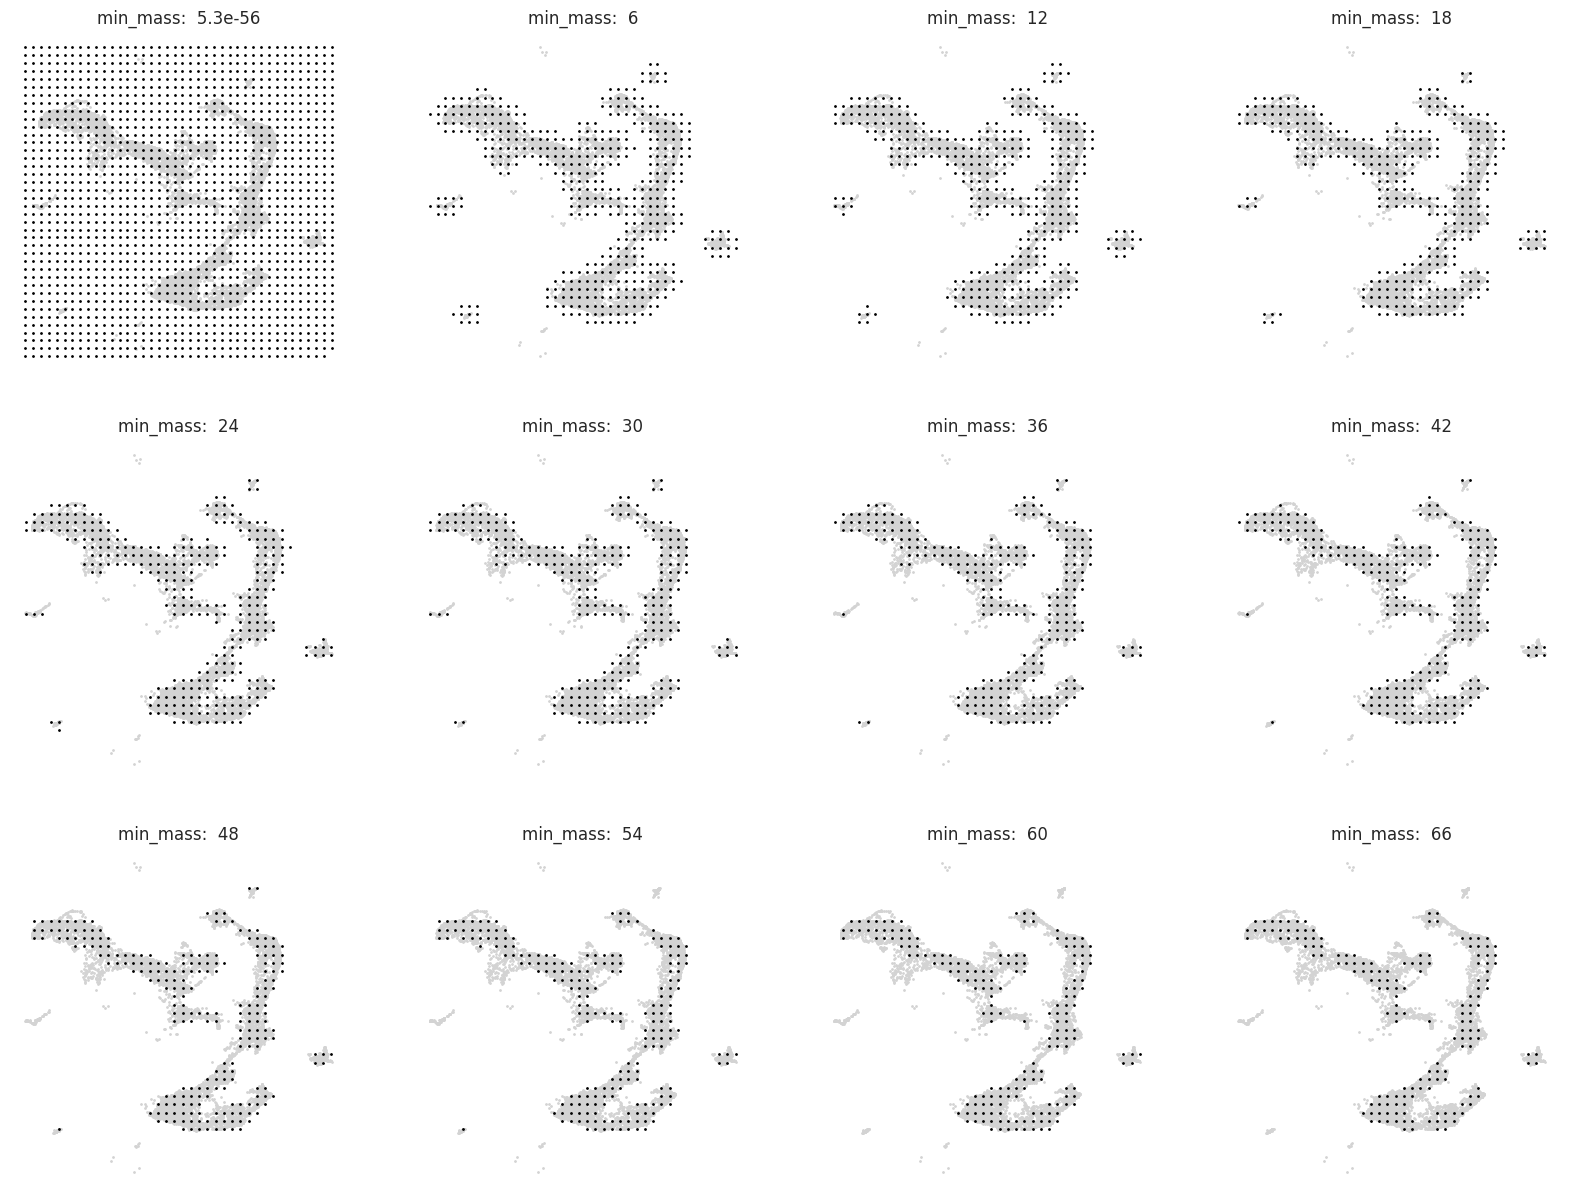

In [ ]:
# n_grid = 40 is a good starting value.
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)

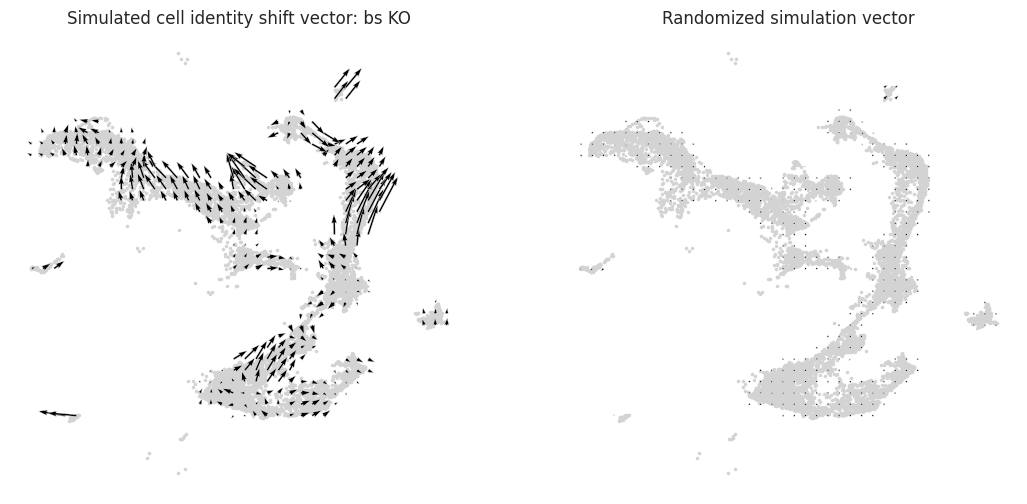

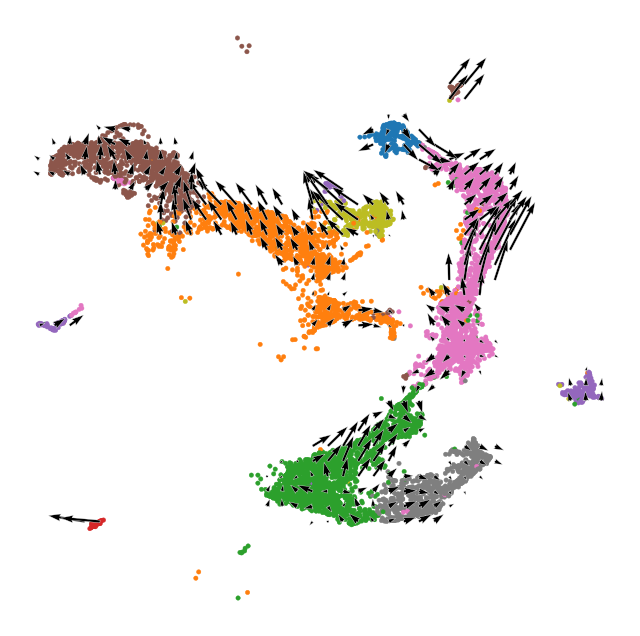

In [ ]:
# oracle.calculate_mass_filter(min_mass=30, plot=True)

fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 10
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

# Plot vector field with cell cluster
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

In [ ]:
def group_patch(adata, func, layer, group_by, *arg, **kwarg):
    groups = np.unique(adata.obs[group_by])
    return [func(adata.layers[layer][adata.obs[group_by] == gr], *arg, **kwarg) for gr in groups], groups

In [ ]:
# computing similarity
aver_expr, clusters = group_patch(oracle.adata, np.mean, "simulated_count", "Classification1", axis=0)
vec_length = np.expand_dims(np.linalg.norm(aver_expr, ord=2, axis=1), axis=0)
cos_similarity1 = (np.array(aver_expr) @ np.array(aver_expr).T) / (vec_length.T @ vec_length)
cos_similarity1[5]

array([0.79733852, 0.92112419, 0.82608328, 0.82640227, 0.91333261,
       1.        , 0.83052606, 0.78981585, 0.89359721])

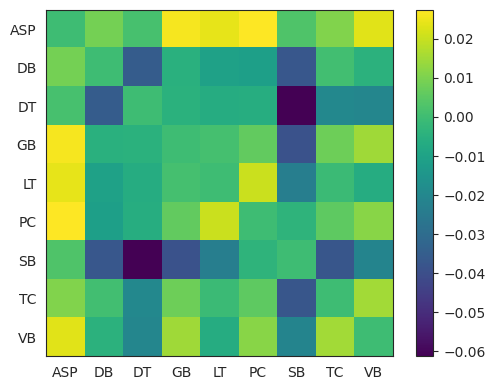

In [ ]:
plt.imshow(cos_similarity1-cos_similarity2, cmap='viridis')
plt.colorbar()
plt.xticks(np.arange(9), labels=clusters)
plt.yticks(np.arange(9), labels=clusters)
plt.show()

In [ ]:
aver_expr, clusters = group_patch(oracle.adata, np.mean, "imputed_count", "Classification1", axis=0)
vec_length = np.expand_dims(np.linalg.norm(aver_expr, ord=2, axis=1), axis=0)
cos_similarity2 = (np.array(aver_expr) @ np.array(aver_expr).T) / (vec_length.T @ vec_length)

In [ ]:
cos_similarity2[5]

array([0.769962  , 0.93237123, 0.83223186, 0.82049971, 0.89303316,
       1.        , 0.83406387, 0.7843231 , 0.88187423])

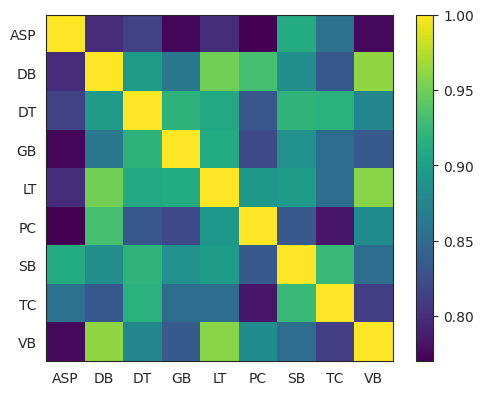

In [ ]:
plt.imshow(cos_similarity, cmap='viridis')
plt.colorbar()
plt.xticks(np.arange(9), labels=clusters)
plt.yticks(np.arange(9), labels=clusters)
plt.show()